### Ch15: Apply PCA On NIH chest X ray

Using cache found in /home/jupyter/.cache/torch/hub/facebookresearch_dino_main
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


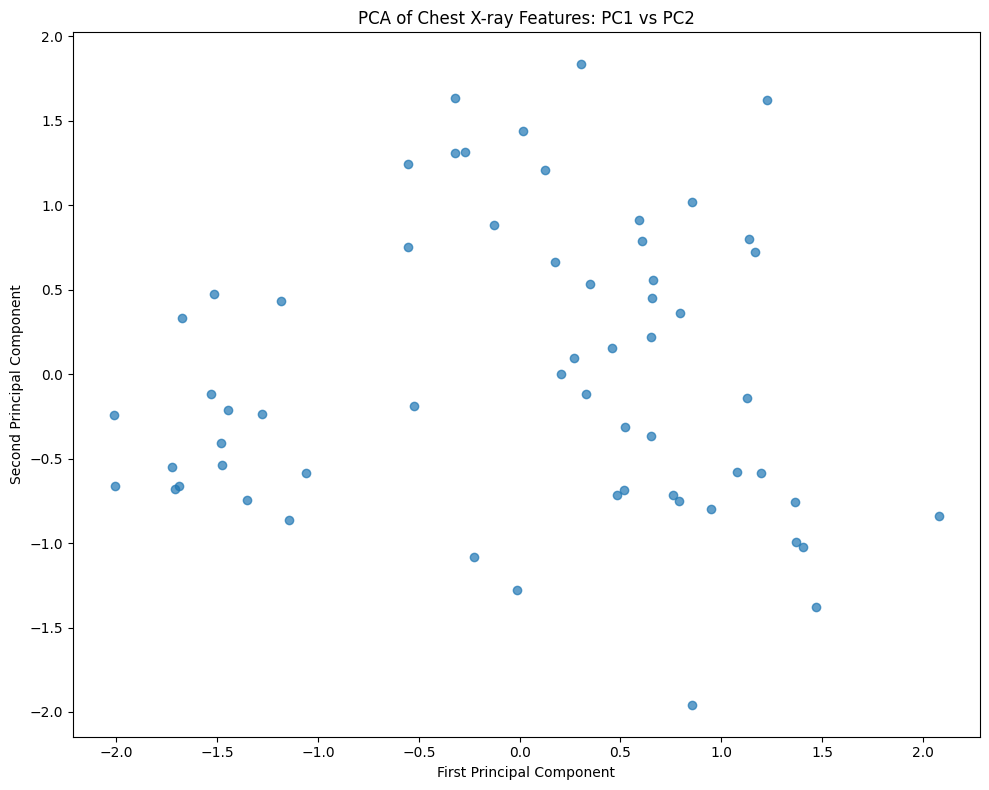

In [24]:
import time
start_time=time.time()
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Set up the DINO ResNet model
def load_dino_model():
    model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    return model, device

# Step 2: Create a function to load and preprocess images
def preprocess_combined_image(image_paths, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load and combine up to three grayscale images into RGB channels
    combined_image = Image.new('RGB', (256, 256))
    for i, path in enumerate(image_paths[:3]):
        img = Image.open(path).convert('L').resize((256, 256))
        combined_image.paste(img, (0, 0), mask=img.split()[0])
        
    return transform(combined_image).unsqueeze(0).to(device)

# Step 3: Extract features for combined image
def extract_features(model, image_paths, device):
    combined_image = preprocess_combined_image(image_paths, device)
    with torch.no_grad():
        features = model(combined_image)
    return features.squeeze().cpu().numpy()

# Main process
def process_images(base_path, num_images=600):
    model, device = load_dino_model()
    image_features = {}

    # Get all image files
    all_image_files = sorted([f for f in os.listdir(base_path) if f.endswith('.png')])
    
    # Group images by base name
    image_groups = defaultdict(list)
    for image_file in all_image_files:
        base_name = image_file.split('_')[0]
        image_groups[base_name].append(image_file)
    
    # Process only the first 600 base images
    for i, (base_name, sub_images) in enumerate(image_groups.items()):
        if i >= num_images:
            break
        
        # Full paths to the sub-images
        image_paths = [os.path.join(base_path, img) for img in sub_images[:3]]
        
        # Extract features
        features = extract_features(model, image_paths, device)
        
        # Store features
        image_features[base_name] = features

    return image_features

# Perform PCA and plot
def plot_pca(features):
    # Convert features to a 2D numpy array
    feature_array = np.array(list(features.values()))
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_array)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('PCA of Chest X-ray Features: PC1 vs PC2')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio
    # print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


base_path = 'all_bucket/marketplace-c3kdc8vj/NIH Chest X-ray/105/artifactFiles/images'
result = process_images(base_path, num_images=60)

# Plot PCA
plot_pca(result)

# # Print results
# for base_name, features in result.items():
#     print(f"Image {base_name}: Feature vector shape: {features.shape}")
        

In [25]:
end_time=time.time()
print(f"total_time:{end_time-start_time}")

total_time:3.5345702171325684
